In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pickle

from ds import Datas

## Load data

In [3]:
# LOAD Datas()
file = open("../../data/PO_norm_part3_mult4.txt", "rb")
data = pickle.load(file)
file.close()

print(np.shape(data.is_optimum)) # [n_bvars, n_instances, n_Mstrategies]
print(data.M_strategies)

(7, 1000, 2)
['our_M', 'qiskit_M']


In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["o", ">", "s"]
#M_strategies = [r"$M_{SDP}$", r"$M_{l_1}$", "optimal_M", "babbush_M"]
M_strategies = [r"$M_{SDP}$", r"$M_{l_1}$"]
plot_M = [1, 1, 0, 0]

## Big-$M$

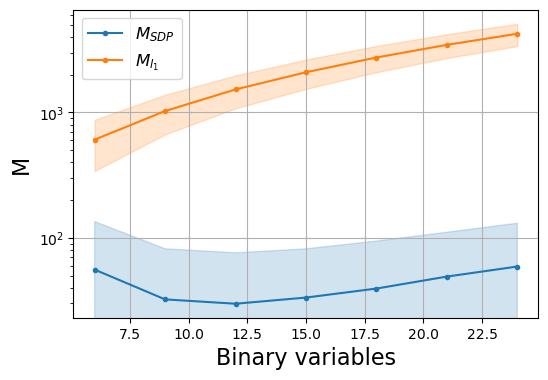

In [5]:
def statistics_M(M):
    avg = np.mean(M[:,:,:], axis = 1)
    std = np.std(M[:,:,:], axis = 1)
    return avg, std

avg_M, std_M = statistics_M(data.M)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], marker = ".", color = colors[i], label=M_strategies[i])
        plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i],
         color = colors[i], alpha=.2)
plt.grid()
#plt.ylim(-100, 100)
plt.yscale("log")
ax1.legend(fontsize = 12, loc='best')
#ax1.set_xticks(data.bvars)
plt.show()

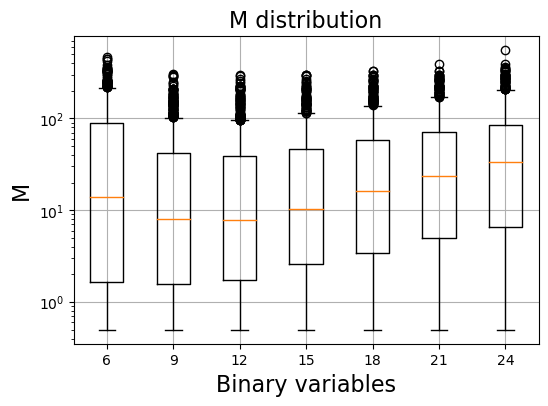

In [6]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('M distribution', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('M', fontsize = 16)
box1 = ax1.boxplot(np.swapaxes(data.M[...,0], axis1=0, axis2=1), labels = data.bvars) # , patch_artist=True
#plt.ylim(0, 1)
plt.yscale("log")
plt.grid()
plt.show()

### Fitting M

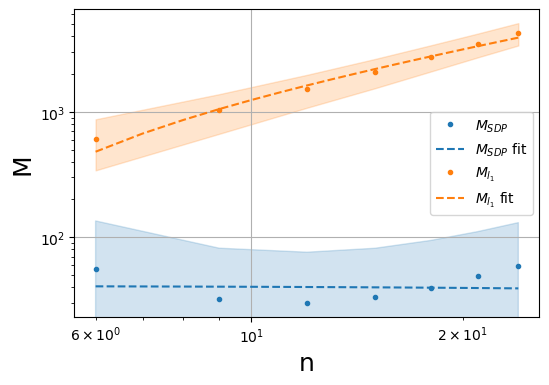

SDP
par[0]:	-0.083 \pm 0.924 	(1118.85%)
par[1]:	41.053 \pm 13.343 	(32.5%)
l1
par[0]:	190.66 \pm 9.159 	(4.8%)
par[1]:	-662.792 \pm 132.245 	(19.95%)


In [8]:
f_linear = lambda n, a, b: a*n + b
f_powlaw = lambda n, a, b : a*n**b
f_inv = lambda n, a, b: a/n + b
funct = f_linear

n_parameters = 2
_, _, n_M = np.shape(data.is_feasible)

start_point = 0
end_point = -1

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[start_point:end_point], avg_M[start_point:end_point,i])
    coef_err[:,i] = np.sqrt( np.diag(coef_cov[...,i]) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('n', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
for i in range(n_M):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], ".", color = colors[i], label=M_strategies[i])
        plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i], color = colors[i], alpha=.2)
        plt.plot(np.arange(data.bvars[0], data.bvars[-1] + 1),
                funct(np.arange(data.bvars[0], data.bvars[-1] + 1), *coef[:,i]), "--",
                color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
#plt.ylim(0, 5e3)
plt.yscale("log")
plt.xscale("log")
ax1.legend(fontsize = 10, loc='center right')
#ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

words = ["SDP", "l1"]
for i in range(len(words)):
    print(words[i])
    for j in range(n_parameters):
        print(f"par[{j}]:\t{np.round(coef[j,i], 3)} \pm {np.round(coef_err[j,i], 3)} \t({np.round(np.abs(coef_err[j,i]/coef[j,i]*100), 2)}%)")

## Gaps

In [9]:
def statistics_gaps(gap):
    avg = np.mean(gap[:,:,:], axis = 1)
    std = np.std(gap[:,:,:], axis = 1)
    return avg, std

avg_gap, std_gap = statistics_gaps(data.gap_norm)

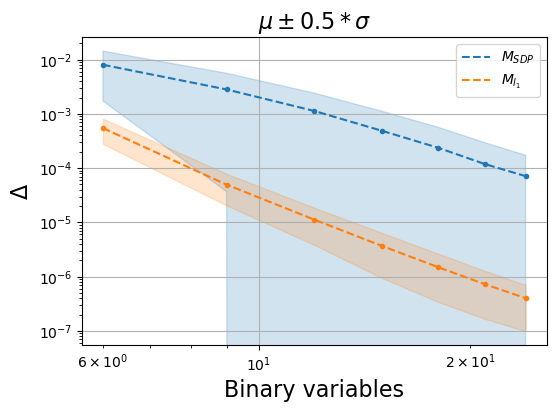

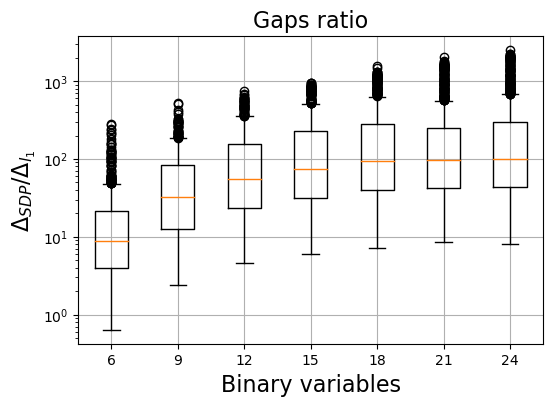

In [10]:
ratio_stddev = 0.5
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(f'$\mu \pm {ratio_stddev}*\sigma$', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_gap[:,i], "--", label=M_strategies[i],  color = colors[i])
        plt.plot(data.bvars, avg_gap[:,i], ".",  color = colors[i])
        plt.fill_between(data.bvars, avg_gap[:,i] - ratio_stddev*std_gap[:,i], avg_gap[:,i] + ratio_stddev*std_gap[:,i],
          color = colors[i], alpha=.2)
plt.grid()
plt.yscale("log")
plt.xscale("log")
ax1.legend(fontsize = 10, loc='upper right')
#plt.ylim(1e-5,2e-2)
plt.show()

indexes_to_plot = list(np.arange(-7, 0))   # PO_part3_ra10_mult4
#ndexes_to_plot = list(np.arange(1, 21,3)) # SPP_p25
#indexes_to_plot = list(np.arange(0, 23, 3)) # NN_deg5
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gaps ratio', fontsize = 16)
ax1.set_xlabel('Binary variables', fontsize = 16)
ax1.set_ylabel('$\Delta_{SDP} / \Delta_{l_1}$', fontsize = 16)
box1 = ax1.boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data.gap_norm[indexes_to_plot,:,1], axis1=0, axis2=1), labels = data.bvars[indexes_to_plot]) # , patch_artist=True
#plt.setp(box1['whiskers'], color="C0")
#plt.setp(box1['caps'], color="C0")
#plt.setp(box1["fliers"], markeredgecolor="C2")
#plt.setp(box1["boxes"], facecolor="C0")
#plt.axhline(1)
#plt.ylim(2, 4000)
plt.yscale("log")
plt.grid()
plt.show()


### Fitting gaps

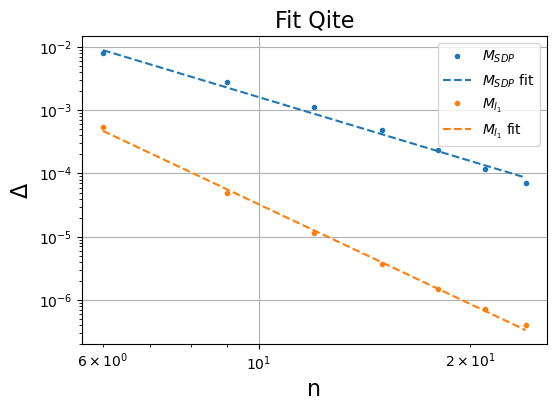

Our fit: 3.62 x^-3.35
par[0]:	3.621 \pm 14.066 	(388.42%)
par[1]:	-3.351 \pm 1.581 	(47.18%)
Qiskit fit: 5.59 x^-5.24
par[0]:	5.594 \pm 15.561 	(278.17%)
par[1]:	-5.235 \pm 1.115 	(21.3%)


In [12]:
f_pl = lambda x, a, b : a*x**b
f_exp = lambda x, a, b : a*b**x
funct = f_pl

n_parameters = 2
startpoint = 0
n_M = 2

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[startpoint:], avg_gap[startpoint:,i],
                                sigma = std_gap[startpoint:,i],
                                absolute_sigma = True)
    coef_err[:,i] = np.sqrt(np.diag(coef_cov[...,i]))
# sigma in curve_fit gives the uncertainty in ydata

def RSS(x, y, f):
    return np.sum( np.square(y - f(x)) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Fit Qite', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(n_M):
    if plot_M[i]:
        plt.plot(data.bvars, avg_gap[:,i], ".", label=M_strategies[i],  color = colors[i])
        plt.plot(data.bvars, funct(data.bvars, *coef[:,i]), "--", color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5, 3e-2)
#plt.xlim(9, 26)
ax1.legend(fontsize = 10, loc='upper right')
plt.show() 


word = ["SDP", "l1"]
for i in range(n_M):
    print(f"{word[i]} fit: {np.round(coef[0,i], 2)} x^{np.round(coef[1,i], 2)}")
    for j in range(2):
        print(f"par[{j}]:\t{np.round(coef[j,i], 3)} \pm {np.round(coef_err[j,i], 3)} \t({np.round(np.abs(coef_err[j,i]/coef[j,i]*100), 2)}%)")